In [11]:
import csv
import copy
import dateutil.parser
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 9)
pd.set_option('display.precision', 10)

In [2]:
# ex1.1 alternate pandas - no dictionary
mtaa = pd.read_csv('turnstile_160903.txt')
mtaa.shape

(193139, 11)

In [3]:
mtaa

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,04:00:00,REGULAR,5799463,1966044
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,08:00:00,REGULAR,5799492,1966079
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,12:00:00,REGULAR,5799610,1966155
...,...,...,...,...,...,...,...,...,...,...,...
193135,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/02/2016,09:00:00,REGULAR,5554,259
193136,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/02/2016,13:00:00,REGULAR,5554,259
193137,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/02/2016,17:00:00,REGULAR,5554,259
193138,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/02/2016,21:00:00,REGULAR,5554,259


In [5]:
# ex1.2 turn time column into time object
mtaa['timestamp'] = (mtaa['DATE'] + ' ' + mtaa['TIME']).apply(lambda x : dateutil.parser.parse(x))
# convert DATE and TIME columes into time objects
mtaa['DATE'] = mtaa['timestamp'].map(lambda x: x.date())
mtaa['TIME'] = mtaa['timestamp'].map(lambda x: x.time())
mtaa2 = mtaa.set_index(['C/A', 'UNIT', 'SCP', 'STATION'])

# increase speed
mtaa2.sortlevel(level=0, inplace=True)

In [6]:
# ex1.3

mtaa2['entry_nxt'] = 0

for ind_1 in mtaa2.index.unique():
    mtaa2.ix[ind_1, 'entry_nxt'] = np.array(mtaa2.ix[ind_1]['ENTRIES'].shift(periods = -1))\
    - np.array(mtaa2.ix[ind_1]['ENTRIES']) # creates NaN on the last row for each index


mtaa2 = mtaa2.dropna() # remove NaN
mtaa2 = mtaa2[(0< mtaa2['entry_nxt']) & (mtaa2['entry_nxt'] < 10000)] # remove negative counts and obviously too large values

mtaa2['entry_nxt'].sort_values()

In [17]:
# prepare for plot in ex1.4
mtaa3 = mtaa2.reset_index()
mtaa3 = mtaa3.groupby(['C/A','UNIT','SCP','STATION','DATE']).sum()
mtaa3 = mtaa3.reset_index()
mtaa3 = mtaa3.set_index(['C/A','UNIT','SCP','STATION'])
mtaa3

DATE   ENTRIES  \
C/A   UNIT SCP      STATION                               
A002  R051 02-00-00 59 ST          2016-08-27  34797961   
                    59 ST          2016-08-28  34802575   
                    59 ST          2016-08-29  34807884   
                    59 ST          2016-08-30  34817299   
...                                       ...       ...   
TRAM2 R469 00-05-00 RIT-ROOSEVELT  2016-08-28      4711   
                    RIT-ROOSEVELT  2016-08-30      4715   
                    RIT-ROOSEVELT  2016-08-31      4719   
                    RIT-ROOSEVELT  2016-09-02      2362   

                                   EXITS                                                                 \
C/A   UNIT SCP      STATION                                                                               
A002  R051 02-00-00 59 ST                                                   11796804                      
                    59 ST                                                   11798274                      
                    59 ST                                                   11800679                      
                    59 ST                                                   11803720                      
...                                                                              ...                      
TRAM2 R469 00-05-00 RIT-ROOSEVELT                                                124                      
                    RIT-ROOSEVELT                                                124                      
                    RIT-ROOSEVELT                                                124                      
                    RIT-ROOSEVELT                                                 62                      

                                   entry_nxt  
C/A   UNIT SCP      STATION                   
A002  R051 02-00-00 59 ST              810.0  
                    59 ST              682.0  
                    59 ST             1580.0  
                    59 ST             1557.0  
...                                      ...  
TRAM2 R469 00-05-00 RIT-ROOSEVELT        2.0  
                    RIT-ROOSEVELT        2.0  
                    RIT-ROOSEVELT        3.0  
                    RIT-ROOSEVELT        1.0  

[28433 rows x 4 columns]

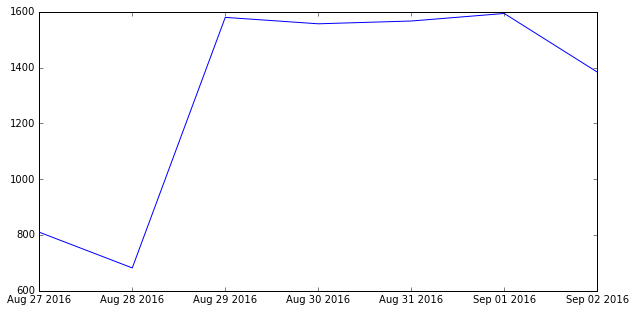

In [18]:
%matplotlib inline
# ex1.4 plot for one turnstile

mtaa3_1 = mtaa3.ix[('A002', 'R051', '02-00-00', '59 ST')]
dates = mtaa3_1.ix[:,'DATE']
counts = mtaa3_1.ix[:,'entry_nxt']

fig, ax = plt.subplots(1,1,figsize=[10,5])
ax.plot(dates, counts)

In [19]:
# ex1.5 combine all turnstiles in a station
mtaa3 = mtaa3.reset_index()
mtaa3 = mtaa3.groupby(['C/A','UNIT','STATION','DATE']).sum()
mtaa3 = mtaa3.reset_index()
mtaa3 = mtaa3.set_index(['C/A','UNIT','STATION'])
mtaa3

DATE    ENTRIES  \
C/A   UNIT STATION                                
A002  R051 59 ST          2016-08-27  339083534   
           59 ST          2016-08-28  334460339   
           59 ST          2016-08-29  339196944   
           59 ST          2016-08-30  339293228   
...                              ...        ...   
TRAM2 R469 RIT-ROOSEVELT  2016-08-30   45840280   
           RIT-ROOSEVELT  2016-08-31   45862843   
           RIT-ROOSEVELT  2016-09-01   44044934   
           RIT-ROOSEVELT  2016-09-02   40409940   

                          EXITS                                                                 \
C/A   UNIT STATION                                                                               
A002  R051 59 ST                                                  192587271                      
           59 ST                                                  187014555                      
           59 ST                                                  192664141                      
           59 ST                                                  192723348                      
...                                                                     ...                      
TRAM2 R469 RIT-ROOSEVELT                                            2358170                      
           RIT-ROOSEVELT                                            2358723                      
           RIT-ROOSEVELT                                            2339860                      
           RIT-ROOSEVELT                                            2279610                      

                          entry_nxt  
C/A   UNIT STATION                   
A002  R051 59 ST             9302.0  
           59 ST             7674.0  
           59 ST            16086.0  
           59 ST            16703.0  
...                             ...  
TRAM2 R469 RIT-ROOSEVELT     3912.0  
           RIT-ROOSEVELT     3746.0  
           RIT-ROOSEVELT     3365.0  
           RIT-ROOSEVELT     3972.0  

[5009 rows x 4 columns]

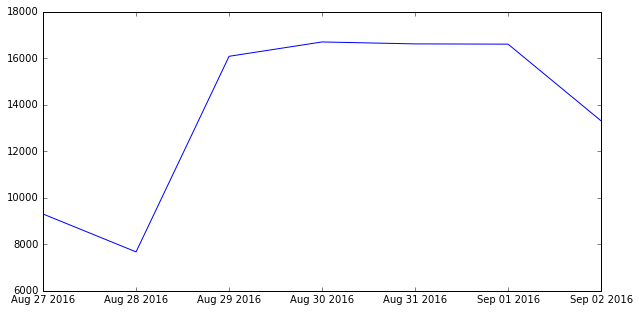

In [20]:
# ex1.6 ex1.7 plot for a station
%matplotlib inline

mtaa3_1 = mtaa3.ix[('A002', 'R051', '59 ST'),:]
dates = mtaa3_1.ix[:,'DATE']
counts = mtaa3_1.ix[:,'entry_nxt']

fig, ax = plt.subplots(1,1,figsize=[10,5])
ax.plot(dates, counts)

In [27]:
# define a function to do everything we have done so far for ex1.8 (multiple weeks)

def create_count_list(filename, station_key):

    # ex1.1 alternate pandas - no dictionary
    mtaa = pd.read_csv(filename)

    # ex1.2 turn time column into time object
    mtaa['timestamp'] = (mtaa['DATE'] + ' ' + mtaa['TIME']).apply(lambda x : dateutil.parser.parse(x))
    # convert DATE and TIME columes into time objects
    mtaa['DATE'] = mtaa['timestamp'].map(lambda x: x.date())
    mtaa['TIME'] = mtaa['timestamp'].map(lambda x: x.time())
    mtaa2 = mtaa.set_index(['C/A', 'UNIT', 'SCP', 'STATION'])

    # increase speed
    mtaa2.sortlevel(level=0, inplace=True)

    # ex1.3

    mtaa2['entry_nxt'] = 0

    for ind_1 in mtaa2.index.unique():
        mtaa2.ix[ind_1, 'entry_nxt'] = np.array(mtaa2.ix[ind_1]['ENTRIES'].shift(periods = -1))\
        - np.array(mtaa2.ix[ind_1]['ENTRIES']) # creates NaN on the last row for each index

    mtaa2 = mtaa2.dropna() # remove NaN
    mtaa2 = mtaa2[(0< mtaa2['entry_nxt']) & (mtaa2['entry_nxt'] < 10000)] # remove negative counts and obviously too large values

    # ex1.5 combine all turnstiles in a station
    mtaa3 = mtaa2.reset_index()
    mtaa3 = mtaa3.groupby(['C/A','UNIT','STATION','DATE']).sum()
    mtaa3 = mtaa3.reset_index()
    mtaa3 = mtaa3.set_index(['C/A','UNIT','STATION'])
    
    
    mtaa3_1 = mtaa3.ix[station_key,:]
    dates = mtaa3_1.ix[:,'DATE']
    counts = mtaa3_1.ix[:,'entry_nxt']
    
    return dates, counts, mtaa3

In [12]:
station_key = ('A002', 'R051', '59 ST')

filename1 = 'turnstile_160903.txt'
date1, count1, station_df1 = create_count_list(filename1, station_key)

filename2 = 'turnstile_160910.txt'
date2, count2, station_df2 = create_count_list(filename2, station_key)

filename3 = 'turnstile_160917.txt'
date3, count3, station_df3 = create_count_list(filename3, station_key)

filename4 = 'turnstile_160924.txt'
date4, count4, station_df4 = create_count_list(filename4, station_key)

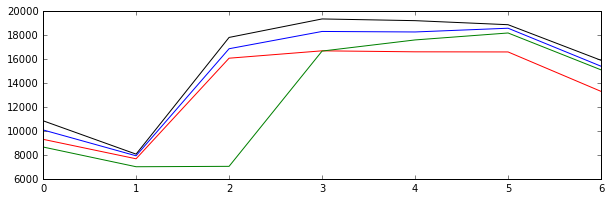

In [81]:
def convert_weekend(date):
    date_w = date.apply(datetime.date.weekday)
    date_w = date_w.apply(lambda x: (x+2)%7)
    return date_w

date1_w = convert_weekend(date1)
date2_w = convert_weekend(date2)
date3_w = convert_weekend(date3)
date4_w = convert_weekend(date4)

# ex1.8 plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(date1_w,count1,'r')
plt.plot(date2_w,count2,'g')
plt.plot(date3_w,count3,'b')
plt.plot(date4_w,count4,'k')

In [82]:
# ex1.9 combine weeks of date into one dataframe
# and find the highest volume

sd1 = station_df1.reset_index()
sd2 = station_df2.reset_index()
sd3 = station_df3.reset_index()
sd4 = station_df4.reset_index()

sd_all = pd.concat([sd1, sd2, sd3, sd4])
sd_all = sd_all.groupby('STATION').sum()
sd_all = sd_all.sort_values('entry_nxt', ascending = False)

# display sorted values
# 34 ST-PENN STA has the highest total entries
sd_all['entry_nxt']

STATION
34 ST-PENN STA     3933459.0
GRD CNTRL-42 ST    3448265.0
34 ST-HERALD SQ    2720424.0
23 ST              2703190.0
                     ...    
BEACH 105 ST          9304.0
BROAD CHANNEL         7797.0
ORCHARD BEACH         1940.0
PATH NEW WTC            14.0
Name: entry_nxt, dtype: float64

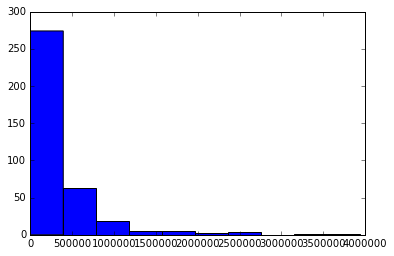

In [80]:
# ex1.10 plot histogram
total_ridership_counts = sd_all['entry_nxt'].tolist()

plt.hist(total_ridership_counts);